# Fertility rate - project for Data Analysis course

## Problem formulation

In recent decades, fertility rates have exhibited notable fluctuations globally, raising concerns about their implications for population dynamics, economic development, and social welfare. Understanding the intricate interplay between socioeconomic variables and fertility rates is essential for policymakers, economists, and social scientists alike. This project aims to delve into this complex relationship, focusing on the impact of Gross Domestic Product (GDP), education, women's labor force participation, and contraception prevalence on fertility rates.

Creating model in the context of the described problem is to develop a tool that can simulate or predict the relationship between various socioeconomic variables and fertility rates. By doing so it is possible to obtain insight into how changes in these factors might influence fertility rates which might be crucial for economists and social scientists in making informed decisions.

The dataset used for this project is sourced from [ourworldindata](https://ourworldindata.org/). Data related to labor force, GDP and education can be found [here](https://ourworldindata.org/fertility-rate),
the data related to spread of contraception can be found [here](https://ourworldindata.org/grapher/fertility-vs-contraception). </br>
* GDP data contains information about: ['Entity', 'Code for entity', 'Year', 'Fertility rate', 'GDP per capita', 'Population (historical estimates)', 'Continent'] </br>
* Labor force data contains information about: ['Entity', 'Code for entity', 'Year', 'Labor force participation rate, female (% of female population ages 15+), 'Fertility rate', 'Population (historical estimates)', 'Continent'] </br>
* Eductaion data contains information about: ['Entity', 'Code for entity', 'Year', 'Fertility rate', 'Combined - average years of education for 15-64 years female youth and adults', 'Population (historical estimates)', 'Continent'] </br>
* Contraception data contains information about: ['Entity', 'Code for entity', 'Year', 'Fertility rate', 'Contraceptive prevalence, any method (% of married women ages 15-49)', 'Continent']

In [3248]:
#TODO DAG model (is it directed acyclic graph?)
#TODO Confoundings (pipe, fork, collider) -> they are related to DAG propably

![title](DAG.png)

pipe: labor force rate -> GDP - more people work means higher GDP

fork GDP -> contraceptive prevalence - bigger budget means people can afford contraception
         -> education years - education costs also accomodation, food etc. while unemployed you dont work so need money from parents or part time jobs give more money; 
         these two can cause confounding

collider: contraceptive prevalence, education years -> fertility rate - more than one causes to change interpretation of causality

### Importing libraries

In [3249]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import arviz as az

from sklearn.model_selection import train_test_split
from cmdstanpy import CmdStanModel

### Reading data from files

In [3250]:
gdp_df = pd.read_csv('/home/children-per-woman-fertility-rate-vs-level-of-prosperity.csv')
labor_df = pd.read_csv('/home/fertility-and-female-labor-force-participation.csv')
education_df = pd.read_csv('/home/womens-educational-attainment-vs-fertility.csv')
contraception_df = pd.read_csv('/home/fertility-vs-contraception.csv')

## Data preprocessing

All data has been cleaned up, all unnecesary columns have been removed. It was performed by using .drop instruction. Also, to make merging data easier to identify, the column name has been changed in some columns by using .rename function. Described processes has been repeated for each dataframe. Removed columns weren't relevant to identify each dataframe or they were useless in terms of analysis.

Since all fertality rates indicators are the same across dataframes, the columns responsible for holding value there were also dropped except for one dataframe.

### Cleaning up GDP dataframe

In [3251]:
gdp_df.columns

Index(['Entity', 'Code', 'Year',
       'Fertility rate - Sex: all - Age: all - Variant: estimates',
       'GDP per capita (output, multiple price benchmarks)',
       'Population (historical estimates)', 'Continent'],
      dtype='object')

In [3252]:
gdp_df.drop(columns=['Code', 'Population (historical estimates)', 'Continent'], inplace=True)
gdp_df.rename(columns={'Fertility rate - Sex: all - Age: all - Variant: estimates':'Fertility rate', 'GDP per capita (output, multiple price benchmarks)':'GDP per capita'}, inplace=True)
gdp_df.head()

,Entity,Year,Fertility rate,GDP per capita
0,Abkhazia,2015,NaN,NaN
1,Afghanistan,1950,7.2484,NaN
2,Afghanistan,1951,7.2596,NaN
3,Afghanistan,1952,7.2601,NaN
4,Afghanistan,1953,7.2662,NaN


### Cleaning up Labor dataframe

In [3253]:
labor_df.columns

Index(['Entity', 'Code', 'Year',
       'Labor force participation rate, female (% of female population ages 15+) (national estimate)',
       'Fertility rate - Sex: all - Age: all - Variant: estimates',
       'Population (historical estimates)', 'Continent'],
      dtype='object')

In [3254]:
labor_df.drop(columns=['Code','Population (historical estimates)', 'Continent', 'Fertility rate - Sex: all - Age: all - Variant: estimates'], inplace=True)
labor_df.rename(columns={'Labor force participation rate, female (% of female population ages 15+) (national estimate)':'Labor force rate'}, inplace=True)
labor_df.head()

,Entity,Year,Labor force rate
0,Abkhazia,2015,NaN
1,Afghanistan,1979,6.830
2,Afghanistan,2008,43.790
3,Afghanistan,2012,16.015
4,Afghanistan,2014,25.784


### Cleaning up Education dataframe

In [3255]:
education_df.columns

Index(['Entity', 'Code', 'Year',
       'Fertility rate - Sex: all - Age: all - Variant: estimates',
       'Combined - average years of education for 15-64 years female youth and adults',
       'Population (historical estimates)', 'Continent'],
      dtype='object')

In [3256]:
education_df.drop(columns=['Code','Population (historical estimates)', 'Continent', 'Fertility rate - Sex: all - Age: all - Variant: estimates'], inplace=True)
education_df.rename(columns={'Combined - average years of education for 15-64 years female youth and adults':'Education years'}, inplace=True)
education_df.head()

,Entity,Year,Education years
0,Abkhazia,2015,NaN
1,Afghanistan,1950,0.08
2,Afghanistan,1951,NaN
3,Afghanistan,1952,NaN
4,Afghanistan,1953,NaN


### Cleaning up Contraception dataframe

In [3257]:
contraception_df.columns

Index(['Entity', 'Code', 'Year', 'Fertility rate, total (births per woman)',
       'Contraceptive prevalence, any method (% of married women ages 15-49)',
       'Continent'],
      dtype='object')

In [3258]:
contraception_df.drop(columns=['Code','Continent','Fertility rate, total (births per woman)'], inplace=True)
contraception_df.rename(columns={'Contraceptive prevalence, any method (% of married women ages 15-49)': 'Contraceptive prevalence'}, inplace=True)
contraception_df.head()

,Entity,Year,Contraceptive prevalence
0,Abkhazia,2015,NaN
1,Afghanistan,1960,NaN
2,Afghanistan,1961,NaN
3,Afghanistan,1962,NaN
4,Afghanistan,1963,NaN


### Merging data and preparing data for further analysis

In order to perform some more advanced actions to the dataset, it is necessary to merge dataset in one big dataset so that is easier to perform further analysis. The merged dataframe has multiple NaN values, which will be removed further.

In [3259]:
merged_df= gdp_df.merge(labor_df, on=['Entity', 'Year'])\
                           .merge(education_df, on=['Entity', 'Year'])\
                           .merge(contraception_df, on=['Entity', 'Year'])

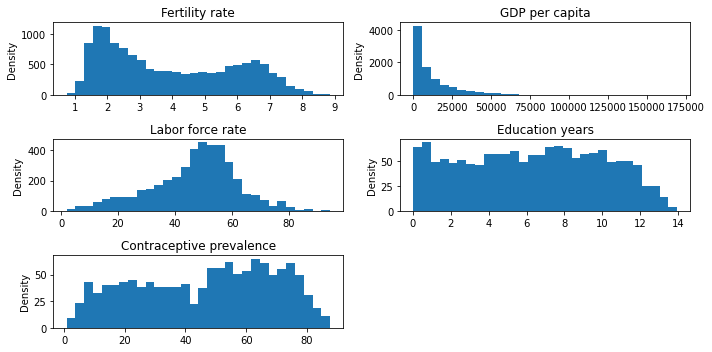

In [3260]:
col_list = ['Fertility rate', 'GDP per capita', 'Labor force rate', 'Education years', 'Contraceptive prevalence']

plt.figure(figsize=(10,5))
for idx in range(len(col_list)):
    plt.subplot(3,2,idx+1)
    plt.hist(merged_df[col_list[idx]], bins=30)
    plt.ylabel('Density')
    plt.title(f'{col_list[idx]}')
plt.tight_layout()
plt.show()

In [3261]:
records_without_nan = merged_df.notna().all(axis=1)
print(f'Records that do not contain NaN after fully joining tables: {records_without_nan.sum()}')

Records that do not contain NaN after fully joining tables: 96


After joining tables, many of the records turned out to have missing data. It is not acceptable, since having full information about each record is necessary for further analysis. Dropping every record that contains NaN leaves us with only 96 records, which is too few. Because of this, we decided to check which column increases records with missing data the most.

In [3262]:
for col in col_list[1:]:
    records_without_nan_dropped = merged_df.drop(columns=col).dropna()
    print(f'Records that do not contain NaN, dropped "{col}": \t{records_without_nan_dropped.shape[0]}')

Records that do not contain NaN, dropped "GDP per capita": 	104
Records that do not contain NaN, dropped "Labor force rate": 	163
Records that do not contain NaN, dropped "Education years": 	602
Records that do not contain NaN, dropped "Contraceptive prevalence": 	632


Column, dropping which leaves the most valid data, is Contraceptive prevalence. However, dropping Education years seems to have nearly the same impact on dataframe. Because of this we decided to plot histograms for both options and decide which one of them provides better data distribution.

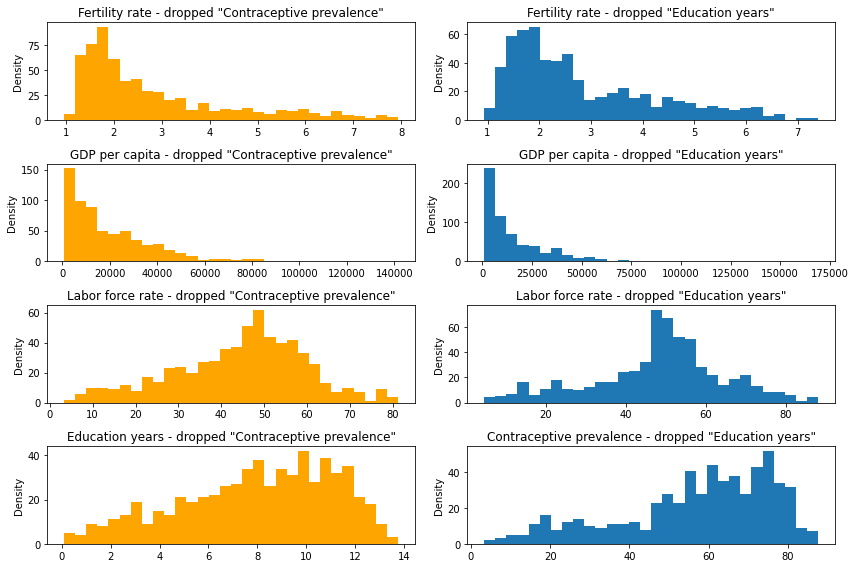

In [3263]:
plt.figure(figsize=(12,8))

education_dropped_df = merged_df.drop(columns='Education years').dropna()
contraception_dropped_df = merged_df.drop(columns='Contraceptive prevalence').dropna()
i=0
for idx in range(len(col_list)):
    if col_list[idx] != 'Contraceptive prevalence':
        plt.subplot(4,2,i+1)
        plt.hist(contraception_dropped_df[col_list[idx]], bins=30, color='orange')
        plt.ylabel('Density')
        plt.title(f'{col_list[idx]} - dropped "Contraceptive prevalence"')
        i+=1
    if col_list[idx] != 'Education years':
        plt.subplot(4,2,i+1)
        plt.hist(education_dropped_df[col_list[idx]], bins=30)
        plt.ylabel('Density')
        plt.title(f'{col_list[idx]} - dropped "Education years"')
        i+=1
plt.tight_layout()
plt.show()


Considering histograms for dataframes with dropped columns and the complete one, we decided to drop "Education years". Histograms for this option show better distribution for "Fertality rate" and we believe that this way we will have more accurate predictions.

In [3264]:
prior_df = education_dropped_df

In [3265]:
countries_appearance = prior_df['Entity'].value_counts()
countries_appearance[countries_appearance.values>5]

Indonesia             26
Japan                 25
Peru                  18
Philippines           18
Vietnam               17
South Korea           16
United States         15
Pakistan              14
Egypt                 14
United Kingdom        13
Thailand              12
Mexico                11
Dominican Republic    10
Turkey                 9
Bangladesh             8
Mongolia               8
Hong Kong              8
Spain                  7
Russia                 7
Colombia               7
El Salvador            7
Bolivia                7
Netherlands            7
Paraguay               6
Ghana                  6
Senegal                6
Georgia                6
Ecuador                6
Name: Entity, dtype: int64

In [3266]:
asia_wealthy = ['Japan', 'South Korea', 'Hong Kong']
asia_poor = ['Indonesia','Vietnam', 'Thailand', 'Philippines', 'Bangladesh', 'Mongolia']
europe = ['United Kingdom', 'Netherlands', 'Germany', 'France', 'Spain', 'Belgium', 'Estonia', 'Russia', 'Georgia', 'Turkey', 'Georgia']
america = ['Peru', 'Dominican Republic', 'United States', 'Mexico', 'Colombia', 'El Salvador', 'Bolivia', 'Paraguay', 'Ecuador']
africa = ['Egypt', 'Pakistan', 'Senegal', 'Palestine', 'Jordan', 'Ghana']

In [3267]:
asia_wealthy_df = prior_df[prior_df['Entity'].isin(asia_wealthy)]
asia_poor_df = prior_df[prior_df['Entity'].isin(asia_poor)]
america_df = prior_df[prior_df['Entity'].isin(america)]
europe_df = prior_df[prior_df['Entity'].isin(europe)]
africa_df = prior_df[prior_df['Entity'].isin(africa)]

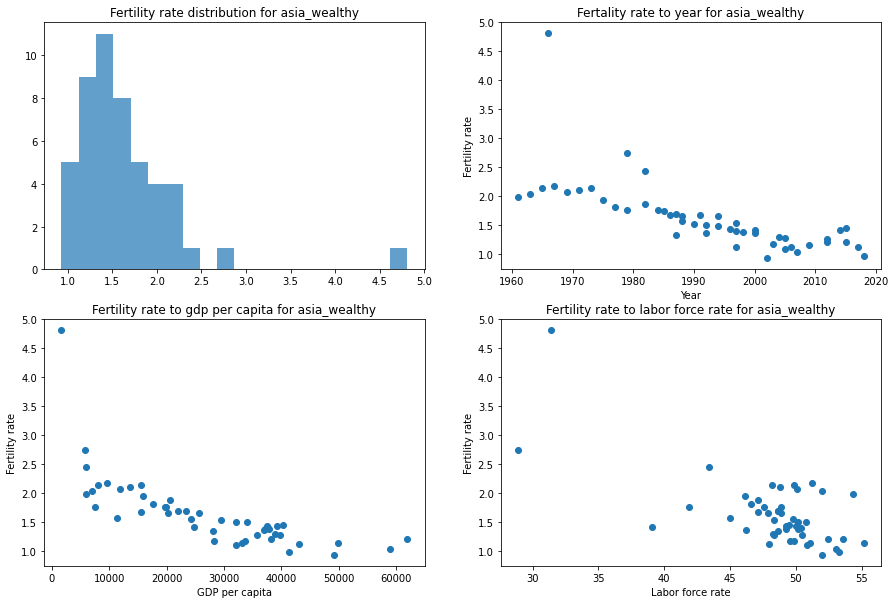

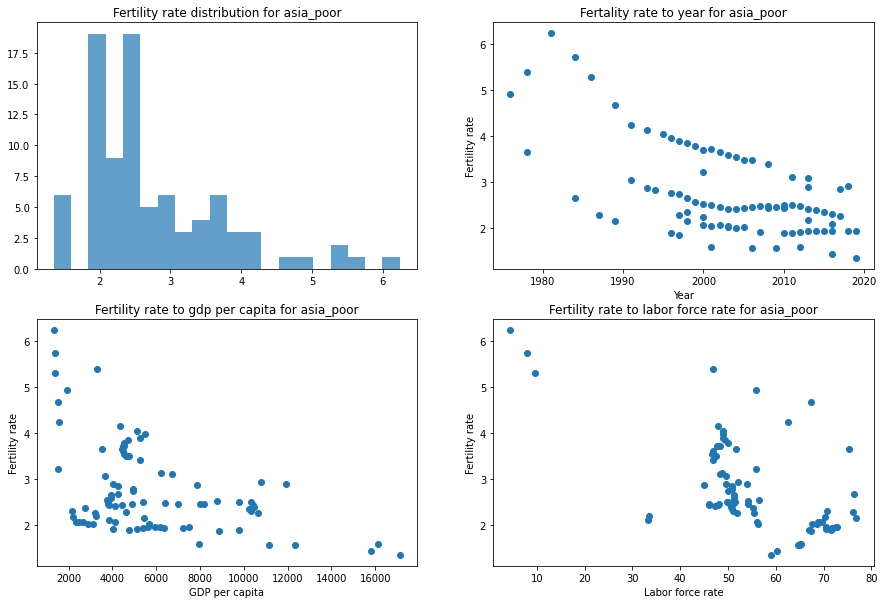

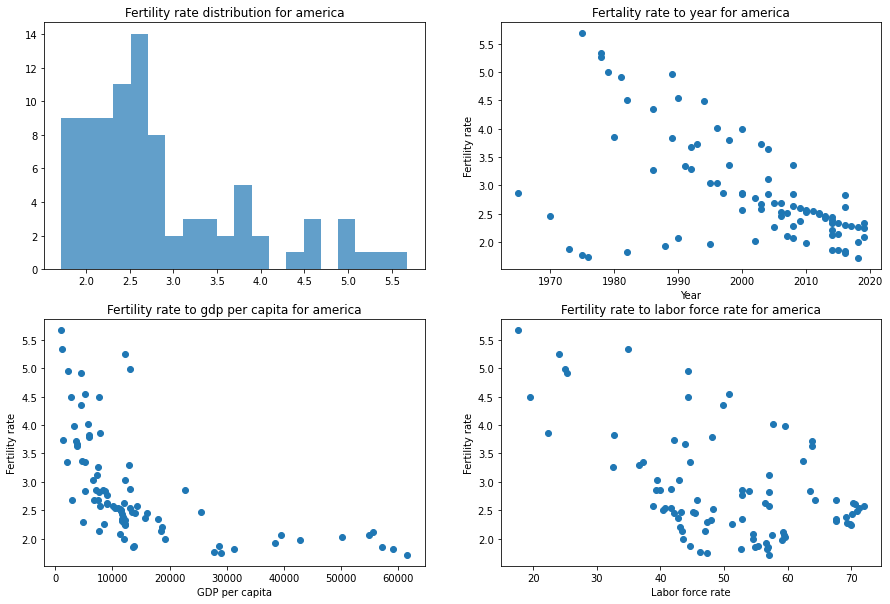

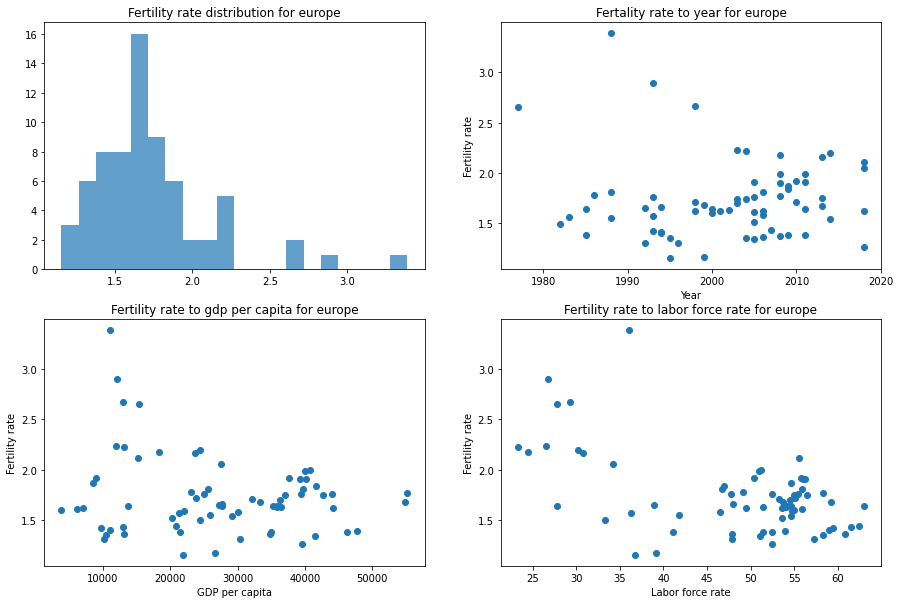

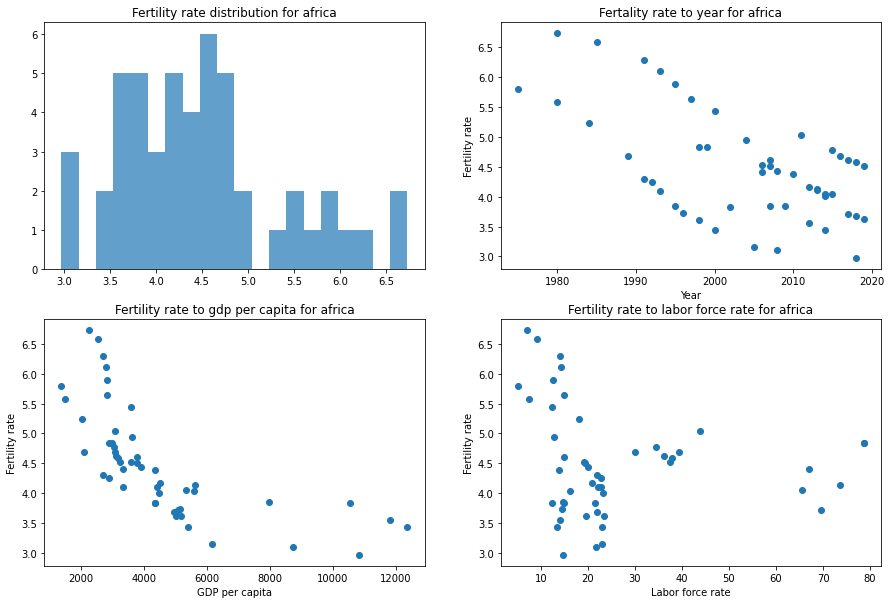

In [3268]:
dfs = [asia_wealthy_df, asia_poor_df, america_df, europe_df, africa_df]
name = ['asia_wealthy', 'asia_poor', 'america', 'europe', 'africa']

for idx in range(len(dfs)):
    df = dfs[idx]
    plt.figure(figsize=(15,10))
    plt.subplot(2,2,1)
    plt.hist(df['Fertility rate'], bins=20, alpha=0.7)
    plt.title(f'Fertility rate distribution for {name[idx]}')
    plt.subplot(2,2,2)
    plt.scatter(df['Year'], df['Fertility rate'])
    plt.title(f"Fertality rate to year for {name[idx]}")
    plt.xlabel('Year')
    plt.ylabel('Fertility rate')
    plt.subplot(2,2,3)
    plt.scatter(df['GDP per capita'], df['Fertility rate'])
    plt.title(f"Fertility rate to gdp per capita for {name[idx]}")
    plt.xlabel('GDP per capita')
    plt.ylabel('Fertility rate')
    plt.subplot(2,2,4)
    plt.scatter(df['Labor force rate'], df['Fertility rate'])
    plt.title(f"Fertility rate to labor force rate for {name[idx]}")
    plt.xlabel('Labor force rate')
    plt.ylabel('Fertility rate')
    plt.show()


In [3269]:
for idx in range(len(dfs)):
    df = dfs[idx]
    region = name[idx]
    print(f'Region {region}, has {len(df)} records')

Region asia_wealthy, has 49 records
Region asia_poor, has 89 records
Region america, has 87 records
Region europe, has 69 records
Region africa, has 50 records


In [3270]:
prior_df = asia_poor_df

In [3271]:
# prior_df = prior_df[prior_df['Entity']=='Indonesia']

In [3272]:
prior_sorted_df = prior_df.sort_values(by='Year')

training_df, test_df = train_test_split(prior_sorted_df, test_size=0.3, random_state=42)

training_df = training_df.sort_values(by='Year')
test_df = test_df.sort_values(by='Year')

## Model

In [3273]:
#TODO Specify two models
#TODO Explain difference between two models
#TODO Is the difference justified?
#TODO Are models sufficiently described?

## Priors

### GDP

In [3274]:
gdp_prior = CmdStanModel(stan_file='/home/prior_gdp.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [3275]:
data_simulation_gdp = {
    'N': len(training_df),
    'gdp_per_capita': training_df['GDP per capita'].values,
    'mu_alpha': training_df['Fertility rate'].mean(),
    'sig_alpha': training_df['Fertility rate'].std(),
    'mu_beta': 0.75,
    'sig_beta': 0.01,
    'shape' : 0,
    'rate' : 3
}

In [3276]:
R = len(training_df)

sim_gdp = gdp_prior.sample(data=data_simulation_gdp, iter_warmup=500, iter_sampling=R, chains=1, seed=2001)
sim_gdp_df = sim_gdp.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [3315]:
sim_gdp_df.head()

,lp__,accept_stat__,alpha,beta_gdp,y_pred[1],y_pred[2],y_pred[3],y_pred[4],y_pred[5],y_pred[6],...,y_pred[80],y_pred[81],y_pred[82],y_pred[83],y_pred[84],y_pred[85],y_pred[86],y_pred[87],y_pred[88],y_pred[89]
0,0.0,0.0,3.27314,0.740024,4.54442,1.46160,0.956183,2.39094,2.519280,4.76578,...,4.895750,1.433840,1.314760,1.28146,0.849081,2.510090,1.535970,1.966320,0.627578,0.882280
1,0.0,0.0,3.27134,0.754491,1.73111,4.86632,2.438280,3.48790,3.744850,3.22213,...,0.994066,1.496200,1.825650,1.72782,2.149480,1.955910,0.423375,1.124930,2.136330,1.589470
2,0.0,0.0,2.61238,0.749568,3.28136,3.77297,1.635750,2.50472,4.093290,3.45641,...,3.423370,1.544540,2.225390,1.80485,2.889360,2.112330,1.755300,0.777850,0.372089,1.020470
3,0.0,0.0,3.86140,0.737962,2.62370,3.47457,2.778210,2.53205,0.930559,1.63239,...,0.563911,1.949980,2.229540,1.13008,1.293360,0.795079,2.105890,0.971022,0.733835,0.818405
4,0.0,0.0,3.25244,0.767805,2.68239,1.67380,1.802680,3.63816,2.044370,4.24302,...,3.121310,0.543208,0.846481,2.37874,2.330880,1.467340,2.816180,1.201490,0.717942,1.234090


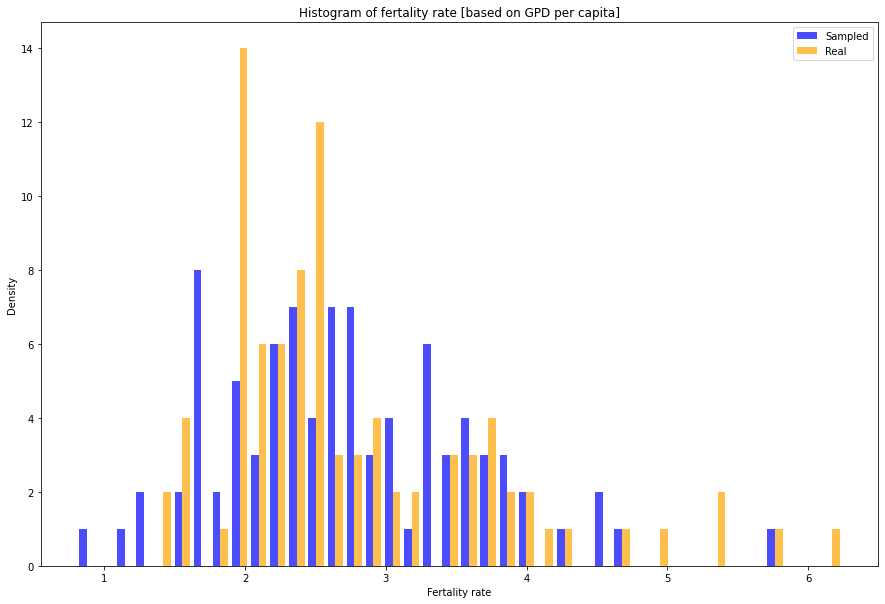

In [3277]:
plt.figure(figsize=(15,10))
plt.title('Histogram of fertality rate [based on GPD per capita]')
plt.hist([sim_gdp_df['y_pred[1]'], prior_df['Fertility rate']], bins=40, alpha=0.7, label=['Sampled', 'Real'], color=['blue', 'orange'])
plt.legend()
plt.ylabel('Density')
plt.xlabel('Fertality rate')
plt.show()

### Combined parameters

In [3278]:
percentage_prior = CmdStanModel(stan_file='/home/prior_combined.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [3279]:
data_simulation_prior_combined = {
    'N': len(training_df),
    'gdp_per_capita': training_df['GDP per capita'].values,
    'labor_force': training_df['Labor force rate'],
    'contaceptive_prevalence' : training_df['Contraceptive prevalence'], 
    'mu_alpha': training_df['Fertility rate'].mean(),
    'sig_alpha': training_df['Fertility rate'].std(),
    'mu_beta': 0.7,
    'sig_beta': 0.05,
    'shape' : 0,
    'rate' : 10
}

In [3280]:
R = len(training_df)

sim_combined_prior = percentage_prior.sample(data=data_simulation_prior_combined, iter_warmup=500, iter_sampling=R, chains=1, seed=2001)
sim_combined_prior_df = sim_combined_prior.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


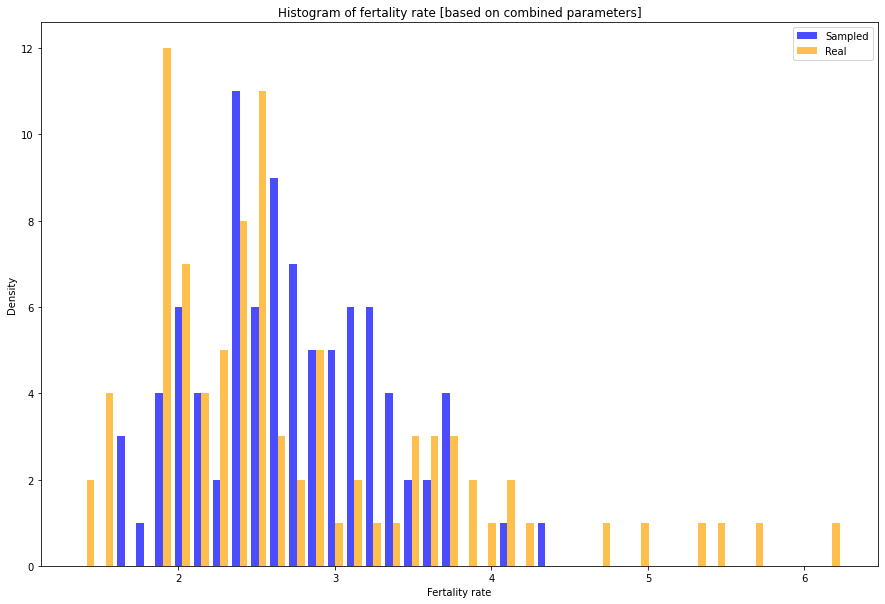

In [3281]:
plt.figure(figsize=(15,10))
plt.title('Histogram of fertality rate [based on combined parameters]')
plt.hist([sim_combined_prior_df['y_pred[1]'], prior_df['Fertility rate']], bins=40, alpha=0.7, label=['Sampled', 'Real'], color=['blue', 'orange'])
plt.legend()
plt.ylabel('Density')
plt.xlabel('Fertality rate')
plt.show()

In [3282]:
#TODO Explain which priors where chosen and why?
#TODO Have prior predictive checks been done for parameters? (simulated parameters makes sense)
#TODO Have prior predictive checks been done for measurements? (simulated measurments makes sense)
#TODO How prior parameters were selected?

## Posteriors analysis - model 1

In [3283]:
gdp_posterior = CmdStanModel(stan_file='/home/posterior_gdp.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [3284]:
data_simulation_gdp_post = {
    'N': len(training_df),
    'gdp_per_capita': training_df['GDP per capita'].values,
    'fertility_rate' : training_df['Fertility rate'].values,
    'mu_alpha': training_df['Fertility rate'].mean(),
    'sig_alpha': training_df['Fertility rate'].std(),
    'mu_beta': 0.75,
    'sig_beta': 0.01,
    'shape' : 0,
    'rate' : 3
}

In [3285]:
R = len(training_df)

sim_post_gdp = gdp_posterior.sample(data=data_simulation_gdp_post, iter_warmup=500, iter_sampling=R, chains=1, seed=2001)
sim_post_gdp_df = sim_post_gdp.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


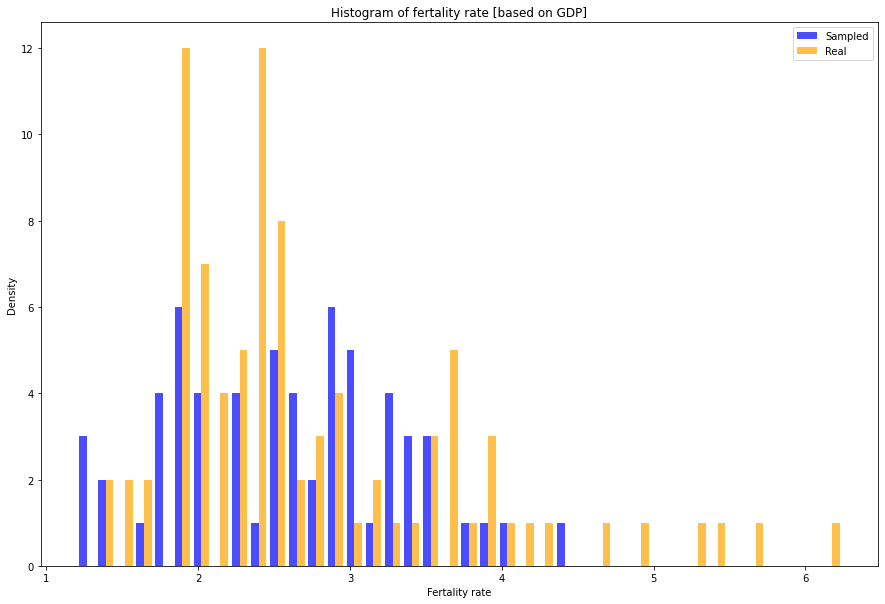

In [3286]:
plt.figure(figsize=(15,10))
plt.title('Histogram of fertality rate [based on GDP]')
plt.hist([sim_post_gdp_df['y_pred[1]'], prior_df['Fertility rate']], bins=40, alpha=0.7, label=['Sampled', 'Real'], color=['blue', 'orange'])
plt.legend()
plt.ylabel('Density')
plt.xlabel('Fertality rate')
plt.show()

Predicting based on posterior analysis

In [3287]:
gdp_alpha_samples = sim_post_gdp.stan_variable('alpha')
gdp_beta_gdp_samples = sim_post_gdp.stan_variable('beta_gdp')

gdp_num_samples= len(gdp_alpha_samples)
gdp_predictions = np.zeros((gdp_num_samples, len(test_df['GDP per capita'])))

In [3288]:
gdp_predict = CmdStanModel(stan_file='/home/posterior_gdp_predict.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [3289]:
for idx in range(gdp_num_samples):
    gdp_predict_data = {
        'N_predict' : len(test_df),
        'gdp_per_capita_predict' : test_df['GDP per capita'].values,
        'alpha_predict' : gdp_alpha_samples[idx],
        'beta_gdp_predict' : gdp_beta_gdp_samples[idx],
        'shape' : data_simulation_gdp_post['shape'],
        'rate' : data_simulation_gdp_post['rate']
    }
    sim_predicted = gdp_predict.sample(data=gdp_predict_data, seed=2001)
    sim_predicted_df = sim_predicted.draws_pd()
    y_pred = sim_predicted.stan_variable('y_pred')
    gdp_predictions[idx, :] = y_pred[0,:]

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status
chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                      

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status
chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status
chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status
chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status



chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                      


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status
chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status
chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                      


chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▎        | 00:00 Iteration: 100 / 1000 [ 10%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                      


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status




chain 1 |█████     | 00:00 Iteration: 900 / 1000 [ 90%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |███▋      | 00:00 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |███▋      | 00:00 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status




chain 1 |████      | 00:00 Iteration: 700 / 1000 [ 70%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status




chain 1 |███▏      | 00:00 Iteration: 500 / 1000 [ 50%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                      


chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:01 Status





chain 1 |██████████| 00:01 Sampling completed                      
chain 2 |██████████| 00:01 Sampling completed

chain 3 |██████████| 00:01 Sampling completed


chain 4 |██████████| 00:01 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status




chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status
chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:   1 / 1000 [  0%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


In [3290]:
gdp_mean_predictions = np.mean(gdp_predictions, axis=0)
gdp_median_predictions = np.median(gdp_predictions, axis=0)

print("Mean of GDP predictions: ", gdp_mean_predictions)
print("Mean of GDP predictions: ", gdp_median_predictions)

Mean of GDP predictions:  [3.16625    5.18016    1.61785371 1.82424403 1.95548839 3.23732016
 4.05965081 1.72984839 0.85743465 2.29831629 2.59854323 1.92551468
 3.17631726 2.36744581 3.79754903 2.43563581 2.75033435 1.14677158
 3.02768    1.64206032 3.49494371 3.12520081 3.1459421  1.95429661
 1.63121984 2.39573792 2.24334629]
Mean of GDP predictions:  [3.17022   5.18354   1.6228    1.82648   1.960825  3.244255  4.067655
 1.73333   0.8613695 2.304045  2.604735  1.86094   3.1831    2.373335
 3.805265  2.44155   2.75652   1.021065  3.134545  1.52509   3.508095
 3.12431   3.23006   1.97893   1.588655  2.52707   2.19567  ]


In [3291]:
years = test_df['Year']
entity = test_df['Entity']

gdp_skeleton = {'Entity' : entity, 
            'Year' : years,
            'Fertility rate' : gdp_mean_predictions}

gdp_predictions_df = pd.DataFrame(gdp_skeleton)

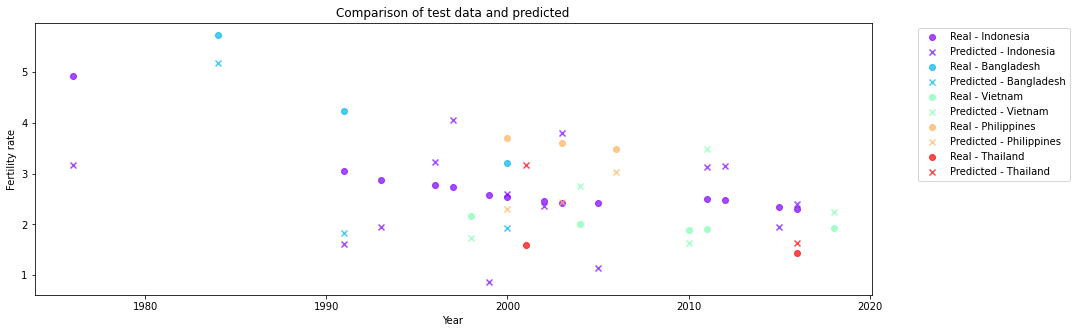

In [3292]:
entities = test_df['Entity'].unique()

plt.figure(figsize=(15, 5))
plt.title("Comparison of test data and predicted")

# Define a color map
colors = plt.cm.rainbow(np.linspace(0, 1, len(entities)))

for i, entity in enumerate(entities):
    # Filter data for the current entity
    real_data = test_df[test_df['Entity'] == entity]
    predicted_data = gdp_predictions_df[gdp_predictions_df['Entity'] == entity]

    # Scatter plot for real data
    plt.scatter(real_data['Year'], real_data['Fertility rate'], color=colors[i], label=f'Real - {entity}', alpha=0.7)

    # Scatter plot for predicted data
    plt.scatter(predicted_data['Year'], predicted_data['Fertility rate'], color=colors[i], marker='x', label=f'Predicted - {entity}', alpha=0.7)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Year")
plt.ylabel("Fertility rate")
plt.show()

In [3293]:
#TODO Any issues with sampling? If so, what ideas of mitigation were used?
#TODO Are samples analyzed?
#TODO Are the data consistent with posterior predictive samples and is it commented sufficiently? (if not is there justification)
#TODO Have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values)

## Posterior analysis - model 2

In [3294]:
posterior_combined = CmdStanModel(stan_file='/home/posterior_combined.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [3295]:
# data_simulation_posterior_combined = {
#     'N': len(training_df),
#     'gdp_per_capita': training_df['GDP per capita'].values/1000,
#     'labor_force' : training_df['Labor force rate'],
#     'contaceptive_prevalence' : training_df['Contraceptive prevalence'], 
#     'fertility_rate' : training_df['Fertility rate'].values,
#     'mu_alpha': training_df['Fertility rate'].mean(),
#     'sig_alpha': training_df['Fertility rate'].std(),
#     'mu_beta': 0.5,
#     'sig_beta': 0.005,
#     'shape' : 4,
#     'rate' : 20
# }


data_simulation_posterior_combined = {
    'N': len(training_df),
    'gdp_per_capita': training_df['GDP per capita'].values,
    'labor_force' : training_df['Labor force rate'],
    'contaceptive_prevalence' : training_df['Contraceptive prevalence'], 
    'fertility_rate' : training_df['Fertility rate'].values,
    'mu_alpha': training_df['Fertility rate'].mean(),
    'sig_alpha': training_df['Fertility rate'].std(),
    'mu_beta': 0.7,
    'sig_beta': 0.05,
    'shape' : 0,
    'rate' : 10
}


In [3296]:
R = len(training_df)

sim_combined = posterior_combined.sample(data=data_simulation_posterior_combined, iter_warmup=500, iter_sampling=R, chains=1, seed=2001)
sim_post_gdp_df = sim_combined.draws_pd()

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


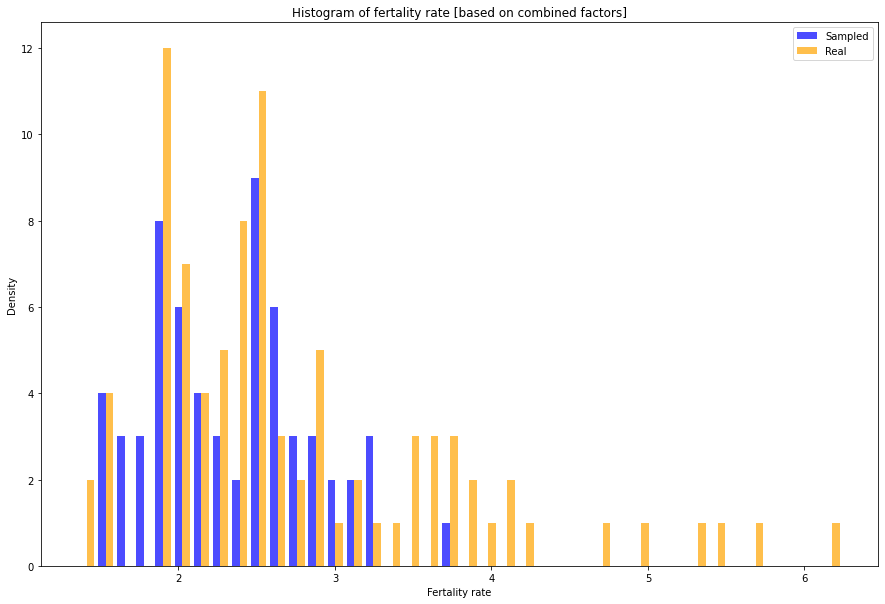

In [3297]:
plt.figure(figsize=(15,10))
plt.title('Histogram of fertality rate [based on combined factors]')
plt.hist([sim_post_gdp_df['y_pred[2]'], prior_df['Fertility rate']], bins=40, alpha=0.7, label=['Sampled', 'Real'], color=['blue', 'orange'])
plt.legend()
plt.ylabel('Density')
plt.xlabel('Fertality rate')
plt.show()

In [3298]:
combined_alpha_samples = sim_combined.stan_variable('alpha')
combined_beta_var_samples = sim_combined.stan_variable('beta_var')
# combined_scale_factor_samples = sim_combined.stan_variable('scale_factor')

combined_num_samples = len(combined_alpha_samples)
combined_predictions = np.zeros((combined_num_samples, len(test_df['GDP per capita'])))

In [3299]:
combined_predict = CmdStanModel(stan_file='/home/posterior_combined_predict.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [3300]:
for idx in range(combined_num_samples):
    combined_predict_data = {
        'N_predict' : len(test_df),
        'gdp_per_capita' : test_df['GDP per capita'].values,
        'labor_force' : test_df['Labor force rate'],
        'contaceptive_prevalence' : test_df['Contraceptive prevalence'],
        'alpha_predict' : combined_alpha_samples[idx],
        'beta_gdp_predict' : combined_beta_var_samples[idx],
        # 'scale_factor_predict' : combined_scale_factor_samples[idx],
        'shape' : data_simulation_gdp_post['shape'],
        'rate' : data_simulation_gdp_post['rate']
    }

    sim_predicted = combined_predict.sample(data=combined_predict_data, seed=2001)
    sim_predicted_df = sim_predicted.draws_pd()
    y_pred = sim_predicted.stan_variable('y_pred')
    combined_predictions[idx, :] = y_pred[0,:]

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration: 600 / 1000 [ 60%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██▎       | 00:00 Iteration: 300 / 1000 [ 30%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:   1 / 1000 [  0%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status



chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      


chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |████▌     | 00:00 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status
chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:01 Status




chain 1 |████▌     | 00:01 Iteration: 800 / 1000 [ 80%]  (Sampling)
chain 1 |██████████| 00:02 Sampling completed                      
chain 2 |██████████| 00:02 Sampling completed                      
chain 3 |██████████| 00:01 Sampling completed                      


chain 4 |██████████| 00:01 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:01 Status
chain 1 |████      | 00:01 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                      
chain 2 |██████████| 00:01 Sampling completed

chain 3 |██████████| 00:01 Sampling completed


chain 4 |██████████| 00:01 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status



chain 1 |████▌     | 00:00 Iteration: 800 / 1000 [ 80%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                      


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▉         | 00:00 Iteration:   1 / 1000 [  0%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status


chain 1 |███▏      | 00:00 Iteration: 500 / 1000 [ 50%]  (Sampling)
chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |▍         | 00:01 Status


chain 1 |██▎       | 00:01 Iteration: 300 / 1000 [ 30%]  (Sampling)

chain 1 |███▋      | 00:01 Iteration: 600 / 1000 [ 60%]  (Sampling)
chain 1 |█████     | 00:01 Iteration: 900 / 1000 [ 90%]  (Sampling)
chain 1 |██████████| 00:01 Sampling completed                      
chain 2 |██████████| 00:01 Sampling completed

chain 3 |██████████| 00:01 Sampling completed


chain 4 |██████████| 00:01 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |████▌     | 00:00 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██▎       | 00:01 Iteration: 300 / 1000 [ 30%]  (Sampling)




chain 1 |████      | 00:01 Iteration: 700 / 1000 [ 70%]  (Sampling)
chain 1 |██████████| 00:02 Sampling completed                      
chain 2 |██████████| 00:02 Sampling completed

chain 3 |██████████| 00:01 Sampling completed


chain 4 |██████████| 00:01 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:01 Status




chain 1 |██████████| 00:01 Sampling completed                      
chain 2 |██████████| 00:01 Sampling completed

chain 3 |██████████| 00:01 Sampling completed


chain 4 |██████████| 00:01 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |███▏      | 00:01 Iteration: 500 / 1000 [ 50%]  (Sampling)


chain 1 |██████████| 00:01 Sampling completed                      
chain 2 |██████████| 00:01 Sampling completed

chain 3 |██████████| 00:01 Sampling completed


chain 4 |██████████| 00:01 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |████      | 00:00 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status
chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |████      | 00:00 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▍         | 00:00 Status
chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status

chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |███▋      | 00:00 Iteration: 600 / 1000 [ 60%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration: 900 / 1000 [ 90%]  (Sampling)

chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      

chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |█████     | 00:00 Iteration: 900 / 1000 [ 90%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed                      
chain 2 |██████████| 00:00 Sampling completed                      
chain 3 |██████████| 00:00 Sampling completed                      


chain 4 |██████████| 00:00 Sampling completed

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed

chain 3 |██████████| 00:00 Sampling completed


chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed                      
chain 4 |██████████| 00:00 Sampling completed                      

INFO:cmdstanpy:CmdStan done processing.


In [3301]:
combined_mean_predictions = np.mean(combined_predictions, axis=0)
combined_median_predictions = np.median(combined_predictions, axis=0)

print("Mean of combined predictions: ", combined_mean_predictions)
print("Mean of combined predictions: ", combined_median_predictions)

Mean of combined predictions:  [ 8.5119879  15.78707742  5.70976806  5.87919984  6.256555    8.44117274
  9.80667145  5.45364274  4.37897919  6.95066677  7.2135629   5.79882161
  8.11385968  6.93926742  9.26247774  4.71331065  9.15527226  9.97347532
  5.86897758  7.23077823  5.75595935  6.7644879   8.29833355  8.54143113
  6.03798016  5.81234258  7.15196452]
Mean of combined predictions:  [ 8.526865 15.8456    5.69502   5.88946   6.244095  8.426085  9.78908
  5.4436    4.368615  6.93745   7.20116   5.801965  8.10456   6.92496
  9.247505  4.70196   9.1425    9.95981   5.858115  7.21438   5.741575
  6.74904   8.28292   8.52407   6.028385  5.79793   7.143865]


In [3302]:
years = test_df['Year']
entity = test_df['Entity']

combined_skeleton = {'Entity' : entity,
            'Year' : years,
            'Fertility rate' : combined_mean_predictions}

combined_predictions_df = pd.DataFrame(combined_skeleton)

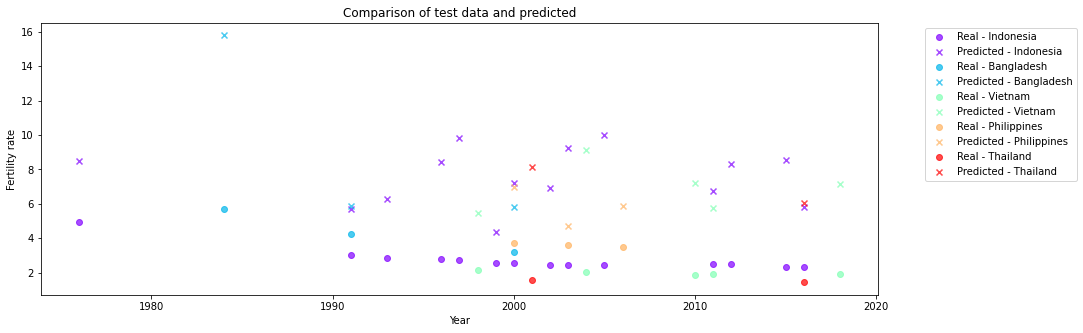

In [3316]:
entities = test_df['Entity'].unique()

plt.figure(figsize=(15, 5))
plt.title("Comparison of test data and predicted")

# Define a color map
colors = plt.cm.rainbow(np.linspace(0, 1, len(entities)))

for i, entity in enumerate(entities):
    # Filter data for the current entity
    real_data = test_df[test_df['Entity'] == entity]
    predicted_data = combined_predictions_df[combined_predictions_df['Entity'] == entity]

    # Scatter plot for real data
    plt.scatter(real_data['Year'], real_data['Fertility rate'], color=colors[i], label=f'Real - {entity}', alpha=0.7)

    # Scatter plot for predicted data
    plt.scatter(predicted_data['Year'], predicted_data['Fertility rate'], color=colors[i], marker='x', label=f'Predicted - {entity}', alpha=0.7)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Year")
plt.ylabel("Fertility rate")
plt.show()

In [3304]:
#TODO Any issues with sampling? If so, what ideas of mitigation were used?
#TODO Are samples analyzed?
#TODO Are the data consistent with posterior predictive samples and is it commented sufficiently? (if not is there justification)
#TODO Have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values)

## Model comparision

In [3305]:
inf_gdp = az.from_cmdstanpy(sim_post_gdp, log_likelihood="log_likelihood")
inf_combo = az.from_cmdstanpy(sim_combined, log_likelihood="log_likelihood")

In [3306]:
comp_dict = {"GDP as factor" : inf_gdp, "GDP, Contraception and Labor as factors" : inf_combo}

In [3307]:
compare_waic = az.compare(comp_dict, ic='waic')
compare_loo = az.compare(comp_dict, ic='loo')

/usr/local/lib/python3.12/site-packages/arviz/stats/stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


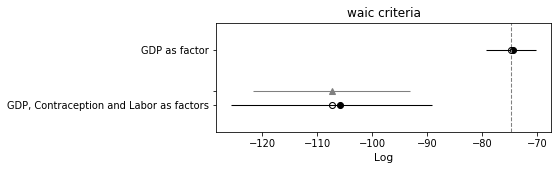

In [3308]:
ax = az.plot_compare(compare_waic)
ax.set_title('waic criteria')
plt.show()

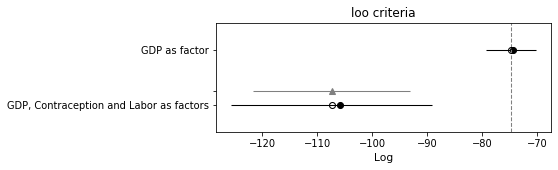

In [3309]:
ax = az.plot_compare(compare_loo)
ax.set_title('loo criteria')
plt.show()

In [3310]:
#TODO Have models been compared using information criteria
#TODO Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings)
#TODO Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings)
#TODO Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another